Hello and welcome to my capstone project on the NJ transit situation. We will be taking a close look at the delays and cancellations of certain lines and seeing if there is any lines in particular that we will need to watch out for improvments. The goal of of this capstone is to create a model with a high enough accuracy to be able to detect when a delay will happen for the line it is observing.
First we will load our data, while printing out how many rows and columns of data there are in order to get a sense of how big of a data set we are dealing with.

In [1]:
#https://www.kaggle.com/pranavbadami/nj-transit-amtrak-nec-performance/version/3

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sb
#read all csv files and concat into one data set called 'data'
data = pd.read_csv('2018_03.csv')
for i in range (4,9):
    data = pd.concat([data, pd.read_csv('2018_0'+str(i)+'.csv')],axis=0,join='inner')
    print(data.shape)

(512775, 13)
(779612, 13)
(1033564, 13)
(1294774, 13)
(1563914, 13)


In [2]:
data.head(10)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953.0,North Elizabeth,109.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit
5,2018-03-01,3805,6.0,North Elizabeth,109.0,Elizabeth,41.0,2018-03-02 01:52:00,2018-03-02 01:52:01,0.016667,departed,Northeast Corrdr,NJ Transit
6,2018-03-01,3805,7.0,Elizabeth,41.0,Linden,70.0,2018-03-02 01:58:00,2018-03-02 01:58:05,0.083333,departed,Northeast Corrdr,NJ Transit
7,2018-03-01,3805,8.0,Linden,70.0,Rahway,127.0,2018-03-02 02:02:00,2018-03-02 02:01:03,0.000000,departed,Northeast Corrdr,NJ Transit
8,2018-03-01,3805,9.0,Rahway,127.0,Metropark,83.0,2018-03-02 02:08:00,2018-03-02 02:08:00,0.000000,departed,Northeast Corrdr,NJ Transit
9,2018-03-01,3805,10.0,Metropark,83.0,Metuchen,84.0,2018-03-02 02:13:00,2018-03-02 02:13:10,0.166667,departed,Northeast Corrdr,NJ Transit


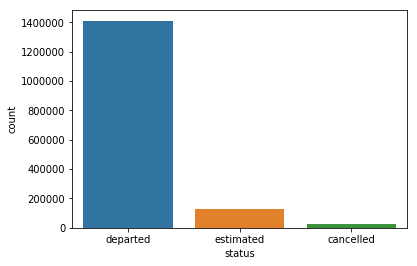

In [3]:
#Create plot to see overall status's of our trains
sb.countplot(data['status'])

Here we can observe that there are in actuality very few lines which are cancelled, and alot of trains do actually depart (and thankfully not cancelled). For the lines that are delayed, which lines are the main culprits?

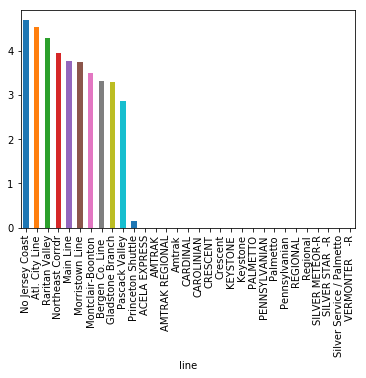

In [4]:
data.groupby('line')['delay_minutes'].mean().sort_values(ascending=False).plot(kind='bar')

After creating a plot which highlights the mean value of delays for the trains, we can observe that there are a fair number of lines that do not have any significant delays, while there are also few which have a very high amount of delays. By creating another bar graph which filters out only longer delays, we can get a better gauge of how the data behaves.

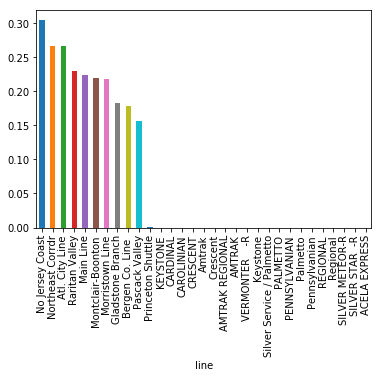

In [5]:
data['long_delay'] = data['delay_minutes'] > 5
data.groupby('line')['long_delay'].mean().sort_values(ascending=False).plot(kind='bar')

It seems that with the data we have, it is pretty consistent with what lines will have notable delays. Lines that have small delays will also have long delays (besides Princeton Shuttle). 

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1563914 entries, 0 to 269139
Data columns (total 14 columns):
date              1563914 non-null object
train_id          1563914 non-null object
stop_sequence     1475201 non-null float64
from              1563914 non-null object
from_id           1563106 non-null float64
to                1563914 non-null object
to_id             1563106 non-null float64
scheduled_time    1475201 non-null object
actual_time       1563914 non-null object
delay_minutes     1475201 non-null float64
status            1563914 non-null object
line              1563914 non-null object
type              1563914 non-null object
long_delay        1563914 non-null bool
dtypes: bool(1), float64(4), object(9)
memory usage: 208.5+ MB
None


In [7]:
data.isna().sum()
data.dropna(inplace=True)

Here we are going to convert scheduled_time to a date time variableso that we can retrieve the individual date and time and seperate them into a different column. In this way we can isolate the start date and the start time and change them into categorical variables. This will help us notice trends for delays on certain start days and times. It is not important to alter the actual_time, as the delay_minutes variable lets us know if its different from the scheduled time.

In [8]:
#create int64 data columns for date
data['numerical date'] = data['date'].str.replace('\D', '').astype(int)
import datetime as dt
data.dropna(inplace=True)
data['scheduled_time'] = data['scheduled_time'].astype(str)
data['s_t_time'] = data['scheduled_time'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').time())
data['s_d_time'] = data['scheduled_time'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())
data.head(10)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type,long_delay,numerical date,s_t_time,s_d_time
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit,False,20180301,01:22:00,2018-03-02
1,2018-03-01,3805,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit,False,20180301,01:31:00,2018-03-02
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit,False,20180301,01:40:00,2018-03-02
3,2018-03-01,3805,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit,False,20180301,01:45:00,2018-03-02
4,2018-03-01,3805,5.0,Newark Airport,37953.0,North Elizabeth,109.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit,False,20180301,01:49:00,2018-03-02
5,2018-03-01,3805,6.0,North Elizabeth,109.0,Elizabeth,41.0,2018-03-02 01:52:00,2018-03-02 01:52:01,0.016667,departed,Northeast Corrdr,NJ Transit,False,20180301,01:52:00,2018-03-02
6,2018-03-01,3805,7.0,Elizabeth,41.0,Linden,70.0,2018-03-02 01:58:00,2018-03-02 01:58:05,0.083333,departed,Northeast Corrdr,NJ Transit,False,20180301,01:58:00,2018-03-02
7,2018-03-01,3805,8.0,Linden,70.0,Rahway,127.0,2018-03-02 02:02:00,2018-03-02 02:01:03,0.000000,departed,Northeast Corrdr,NJ Transit,False,20180301,02:02:00,2018-03-02
8,2018-03-01,3805,9.0,Rahway,127.0,Metropark,83.0,2018-03-02 02:08:00,2018-03-02 02:08:00,0.000000,departed,Northeast Corrdr,NJ Transit,False,20180301,02:08:00,2018-03-02
9,2018-03-01,3805,10.0,Metropark,83.0,Metuchen,84.0,2018-03-02 02:13:00,2018-03-02 02:13:10,0.166667,departed,Northeast Corrdr,NJ Transit,False,20180301,02:13:00,2018-03-02


In [9]:
data['delayed'] = data['delay_minutes'].apply(lambda x: True if x > 0.0 else False)

True     1282219
False     192182
Name: delayed, dtype: int64

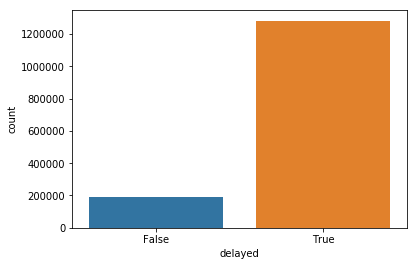

In [10]:
#Create countplot to detect data unbalances in the dataset. 
sb.countplot(data['delayed'])
data['delayed'].value_counts()

In [12]:
# Convert Objects to Categorical
col = ['line', 'status', 'type', 'from', 'to', 'train_id', 's_d_time', 's_t_time', 'train_id', 'delayed']
for i in data[col]:
    if data.dtypes[i] == 'object':
        data[i] = data[i].astype('category').cat.codes

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1474401 entries, 0 to 269127
Data columns (total 18 columns):
date              1474401 non-null object
train_id          1474401 non-null int16
stop_sequence     1474401 non-null float64
from              1474401 non-null int16
from_id           1474401 non-null float64
to                1474401 non-null int16
to_id             1474401 non-null float64
scheduled_time    1474401 non-null object
actual_time       1474401 non-null object
delay_minutes     1474401 non-null float64
status            1474401 non-null int8
line              1474401 non-null int8
type              1474401 non-null int8
long_delay        1474401 non-null bool
numerical date    1474401 non-null int32
s_t_time          1474401 non-null int16
s_d_time          1474401 non-null int16
delayed           1474401 non-null bool
dtypes: bool(2), float64(4), int16(5), int32(1), int8(3), object(3)
memory usage: 156.7+ MB


After converting all the relevant data of the 'object' type data columns into categorical type points, we can use a heatmap to gauge the correlation between the two different features to gain a better understanding of how well our features correlate with our target focus "delayed".

Text(0.5, 1.0, 'Variable Correlation')

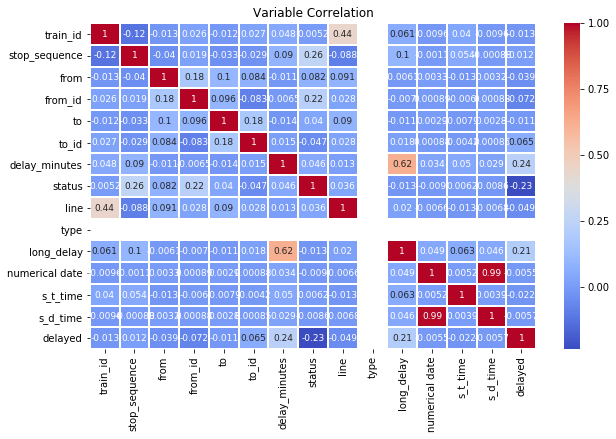

In [14]:
plt.figure(figsize=(10,6))
sb.heatmap(data.corr(),cmap = 'coolwarm',linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

In [15]:
target = data.delayed.copy()

selected_data = data[['line', 'status', 'type', 'from', 'to', 's_d_time', 's_t_time', 'train_id']]
selected_data.head(10)

,line,status,type,from,to,s_d_time,s_t_time,train_id
0,7,1,0,101,101,1,82,582
1,7,1,0,101,136,1,90,582
2,7,1,0,136,104,1,98,582
3,7,1,0,104,102,1,103,582
4,7,1,0,102,106,1,107,582
5,7,1,0,106,37,1,110,582
6,7,1,0,37,65,1,116,582
7,7,1,0,65,125,1,119,582
8,7,1,0,125,76,1,125,582
9,7,1,0,76,77,1,130,582


# Resample

In [16]:
#Utilize SmoteTomek to apply both over and undersampling to the data
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_resampled, y_resampled = smt.fit_sample(selected_data, target)

C:\Users\ronal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [17]:
#Create our testing and training data set, with spread of 70% in training and 30% in testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=20)

import time
start_time = time.time() 
reset_time = time.time() - start_time

Due to our data being heavily weighted in containing data where a train is delayed, in order to achieve the benefits of both oversampling and undersampling of our data we will be utilizing SMOTETomek. This will give us a balanced dataset to work with. 

# Naive Bayes

In [18]:
import warnings
warnings.filterwarnings("ignore")

#Create a normal Naive Bayes plot
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
nb.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 0.8234584331512451 seconds ---


# Regular Decision Tree

In [19]:
from sklearn import tree

#This initiates the DecisionTreeClassifier
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features = 7, #Use 7 of the features
    max_depth = 5 #Tree goes 5 branches down
)
#Fits the decisiontree onto the data
decision_tree.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 5.730699062347412 seconds ---


# Random Forest Tree

In [20]:
from sklearn import ensemble
#Create a generic random forest tree
rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features = 'auto',
    max_depth = 2 ,
    n_estimators = 2,
    n_jobs=-1
    )
#Import GridSearchCV in order to let the algorithm decide which values will be best
from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [20, 30, 40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
gd_sr = GridSearchCV(estimator=rfc,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

gd_sr.fit(X_train, y_train)  
best_result = gd_sr.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.7933319900108504
--- 4521.818781852722 seconds ---


# Gradient Boosted

In [21]:
params = {'n_estimators': 10,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

#Same as RandomForest, import GridSearchCV to use to find the best parameters for the model
from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [20, 30, 40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
}
gd_clf = GridSearchCV(estimator=clf,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

gd_clf.fit(X_train, y_train)  
best_result = gd_clf.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.843478061644403
--- 2141.57173371315 seconds ---


# Logistic Regression

In [22]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
# Set up the regression model to predict defaults using all other
# variables as features.
regr = LogisticRegression(solver='lbfgs')
regrfit = regr.fit(X_train, y_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = regrfit.predict(X_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Use score method to get accuracy of model
print('\n Model accuracy')
score = regr.score(X_test, y_test)
print(score)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time


 Model accuracy
0.5914603137615057
--- 21.97931957244873 seconds ---


# Evalute Data: Regular

In [23]:
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
model_names = [nb, decision_tree, gd_sr, gd_clf, regrfit]
for model_name in model_names:
    print('\n\nModel Type: ', model_name)
    print('\nWith 20% Holdout: ' + str(model_name.fit(X_train, y_train).score(X_test, y_test)))
    print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

    print('\nCross Validation')
    print(cross_val_score(model_name, selected_data, target, cv=10))

    prediction = model_name.predict(X_test)
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(y_test, prediction)
    print('\n Confusion Matrix')
    print(cnf_matrix)

    print('\n Classification Report')
    print(classification_report(y_test, prediction))

    print('\n Roc Auc Score')
    print(roc_auc_score(y_test, prediction))
    print("--- %s seconds ---" % (time.time() - start_time - reset_time))
    reset_time = time.time() - start_time



Model Type:  BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

With 20% Holdout: 0.5319566573228152
Testing on Sample: 0.8837188797348889

Cross Validation
[0.89093264 0.87791049 0.88088036 0.87973413 0.87599023 0.88147043
 0.8818299  0.88353228 0.89358383 0.89132455]

 Confusion Matrix
[[ 23430 341236]
 [   229 364640]]

 Classification Report
             precision    recall  f1-score   support

      False       0.99      0.06      0.12    364666
       True       0.52      1.00      0.68    364869

avg / total       0.75      0.53      0.40    729535


 Roc Auc Score
0.5318114759908668
--- 8.510110855102539 seconds ---


Model Type:  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='be

With no feature selection, out of the all the models I tested the regular decision tree model I created was the most efficient in terms of accuracy and time. Although Naive Bayes also scored fairly well and at a faster time then decision tree, it is much less accurate then that of the decision tree. Gradient Boosting has a higher accuracy then the decision tree, and was able to successfuly attain a higher accuracy in terms of its cross validation, confusion matrix, and roc auc. However its run times displayed that it took 976x longer then the decision tree to generate it's evaluation in comparison to the regular decision tree model for a 2% gain in terms of terms of the cross validation score and 4% gain on the roc auc score. 

Now that we know how no feature selection models perform, let us see how Select K Best will alter our data.

# Select K Best Creation

In [25]:
#Use Select K Best after using PCA to determine the number of dimensions to achieve the 2 features that have the greatest variance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=4)
selector.fit(selected_data, target)

X_new = selector.transform(selected_data)
print(X_new.shape)

selected_data.columns[selector.get_support(indices=True)]
selected_data.columns[selector.get_support(indices=True)].tolist()
#sets newdata to only contain the four features that will give us the most variance
skb_data = selected_data[selected_data.columns[selector.get_support(indices=True)].tolist()].copy()
skb_data.head(10)

#Resample Data
smt = SMOTETomek(ratio='auto')
X_resampled, y_resampled = smt.fit_sample(skb_data, target)

#Create Test/Training set for SKB
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=20)

(1474401, 4)


# Naive Bayes

In [26]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
nb.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 76.92189645767212 seconds ---


In [27]:
# This is the model we'll be using.
from sklearn import tree

#This initiates the DecisionTreeClassifier with the attributes that we want
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features = 2, #Use 7 of the features
    max_depth = 5 #Tree goes 5 branches down
)
#Fits the decisiontree onto the data
decision_tree.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 2.6544699668884277 seconds ---


In [28]:
from sklearn import ensemble
#Create a generic random forest tree
rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features = 'auto',
    max_depth = 2 ,
    n_estimators = 2,
    n_jobs=-1
    )

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [20, 30, 40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
gd_sr = GridSearchCV(estimator=rfc,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

gd_sr.fit(X_train, y_train)  
best_result = gd_sr.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.7369677223821791
--- 4491.949316740036 seconds ---


In [29]:
params = {'n_estimators': 10,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [20, 30, 40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
}
gd_clf = GridSearchCV(estimator=clf,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

gd_clf.fit(X_train, y_train)  
best_result = gd_clf.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.8012661232093989
--- 1778.9402861595154 seconds ---


In [30]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
# Set up the regression model to predict defaults using all other
# variables as features.
regr = LogisticRegression(solver='lbfgs')
regrfit = regr.fit(X_train, y_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = regrfit.predict(X_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Use score method to get accuracy of model
print('\n Model accuracy')
score = regr.score(X_test, y_test)
print(score)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time


 Model accuracy
0.6536666597335608
--- 10.303048372268677 seconds ---


# Evalute SKB models

In [31]:
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
model_names = [nb, decision_tree, gd_sr, gd_clf, regrfit]
for model_name in model_names:
    print('\n\nModel Type: ', model_name)
    print('\nWith 20% Holdout: ' + str(model_name.fit(X_train, y_train).score(X_test, y_test)))
    print('Testing on Sample: ' + str(model_name.fit(skb_data, target).score(skb_data, target)))

    print('\nCross Validation')
    print(cross_val_score(model_name, selected_data, target, cv=10))

    prediction = model_name.predict(X_test)
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(y_test, prediction)
    print('\n Confusion Matrix')
    print(cnf_matrix)

    print('\n Classification Report')
    print(classification_report(y_test, prediction))

    print('\n Roc Auc Score')
    print(roc_auc_score(y_test, prediction))
    print("--- %s seconds ---" % (time.time() - start_time - reset_time))
    reset_time = time.time() - start_time



Model Type:  BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

With 20% Holdout: 0.5426295017523425
Testing on Sample: 0.8837188797348889

Cross Validation
[0.89093264 0.87791049 0.88088036 0.87973413 0.87599023 0.88147043
 0.8818299  0.88353228 0.89358383 0.89132455]

 Confusion Matrix
[[ 33043 351598]
 [   238 384377]]

 Classification Report
             precision    recall  f1-score   support

      False       0.99      0.09      0.16    384641
       True       0.52      1.00      0.69    384615

avg / total       0.76      0.54      0.42    769256


 Roc Auc Score
0.5426436390181805
--- 7.987046241760254 seconds ---


Model Type:  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='be

Using the SelectKBest feature selection model, we once again tested all of the previous models but this time with the SKB dataset. For gradient boost and the decision tree model, the results are roughly the same with fluctuations of about 2% for the accuracy and roc auc score. The random forest model however showed a very large increase in terms of accuracy to the point where its accuracy is on par with the decision tree. This is most likely due to the decreased feature space, the random forest model was able to more accuractely detect the variances in the data and thus generate a more accurate model. Runtime between SKB models and regular models are both roughly similar to one another as well, however the SKB models take roughly 300 seconds more to parse for the random forest and gradient boosted models. 

Time to test this with PCA.

In [32]:
from sklearn.decomposition import PCA
#Here we are setting pca to be fitted with n_components = x, until it encompasses 95% of the variance or more
pca = PCA(.95)
pca_data = pca.fit_transform(selected_data) 
#Shows how much variance the first and second dimensional space has
print("Individual Variance: ", pca.explained_variance_ratio_)
#Shows that I retain 95%+ of the variance
print("Combined Variance: ", pca.explained_variance_ratio_.cumsum())

smt = SMOTETomek(ratio='auto')
X_resampled, y_resampled = smt.fit_sample(pca_data, target)

#Create Test/Training set for PCA
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=20)

Individual Variance:  [0.58456042 0.39231759]
Combined Variance:  [0.58456042 0.976878  ]


In [33]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
nb.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 28.21751308441162 seconds ---


In [34]:
from sklearn import tree

#This initiates the DecisionTreeClassifier with the attributes that we want
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features = 2, #Use 2 of the features
    max_depth = 5 #Tree goes 5 branches down
)
#Fits the decisiontree onto the data
decision_tree.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 5.505842447280884 seconds ---


In [35]:
from sklearn import ensemble
#Create a generic random forest tree
rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features = 'auto',
    max_depth = 2 ,
    n_estimators = 2,
    n_jobs=-1
    )

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [20, 30, 40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
gd_sr = GridSearchCV(estimator=rfc,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

gd_sr.fit(X_train, y_train)  
best_result = gd_sr.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.5705795558269137
--- 4322.59126329422 seconds ---


In [36]:
params = {'n_estimators': 10,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [20, 30, 40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
}
gd_clf = GridSearchCV(estimator=clf,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

gd_clf.fit(X_train, y_train)  
best_result = gd_clf.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.5944745942042579
--- 1562.6130874156952 seconds ---


In [37]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
# Set up the regression model to predict defaults using all other
# variables as features.
regr = LogisticRegression(solver='lbfgs')
regrfit = regr.fit(X_train, y_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = regrfit.predict(X_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Use score method to get accuracy of model
print('\n Model accuracy')
score = regr.score(X_test, y_test)
print(score)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time


 Model accuracy
0.5236201044442442
--- 1.305248498916626 seconds ---


# Evalute PCA Models

In [38]:
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
model_names = [nb, decision_tree, gd_sr, gd_clf, regrfit]
for model_name in model_names:
    print('\n\nModel Type: ', model_name)
    print('\nWith 20% Holdout: ' + str(model_name.fit(X_train, y_train).score(X_test, y_test)))
    print('Testing on Sample: ' + str(model_name.fit(pca_data, target).score(pca_data, target)))

    print('\nCross Validation')
    print(cross_val_score(model_name, selected_data, target, cv=10))

    prediction = model_name.predict(X_test)
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(y_test, prediction)
    print('\n Confusion Matrix')
    print(cnf_matrix)

    print('\n Classification Report')
    print(classification_report(y_test, prediction))

    print('\n Roc Auc Score')
    print(roc_auc_score(y_test, prediction))
    print("--- %s seconds ---" % (time.time() - start_time - reset_time))
    reset_time = time.time() - start_time



Model Type:  BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

With 20% Holdout: 0.5314684414464284
Testing on Sample: 0.8696541849876662

Cross Validation
[0.89093264 0.87791049 0.88088036 0.87973413 0.87599023 0.88147043
 0.8818299  0.88353228 0.89358383 0.89132455]

 Confusion Matrix
[[     0 349332]
 [     0 349797]]

 Classification Report
             precision    recall  f1-score   support

      False       0.00      0.00      0.00    349332
       True       0.50      1.00      0.67    349797

avg / total       0.25      0.50      0.33    699129


 Roc Auc Score
0.5
--- 7.667581558227539 seconds ---


Model Type:  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

With 20% 

For PCA feature selection, we can see that the accuracy across all models is much lower then the models using SKB or no feature selection. Most likely this is due to PCA getting rid of all the significant variances in the data by omiting the outliers in our data. The outliers in this case will be the times where there is a delay in our trains, and therefore our models become unable to predict when delays can occur.

# Conclusion

In conclusion, our best three models to use in detecting delays in the train schedules would be the decision tree, random forest and gradient boost models. For Logistic Regression it was ineffective largely due to being unable to correctly ascertain the right alpha value. Naive Bayes also does not do too well in this scenerio due to the larger data set and its inability to accurately detect and adjust for outliers compared to models like the decision tree. 

Between the three best models, gradient boost worked the best in this scenerio. This is most likely due to the models ability to continually detect outliers in the data and recycle those data back into the model to be retested. This makes it so that even if the parameters you give it are not the best, it'll still be able to detect them. The parameters I chose for random forest in this model, could have been better if I increased the n-estimator and increased the depth range from 1-3 to 1-5. The main problem was that my system was already taking roughly 2 days to parse through all the models, and I was afraid that increasing the depth of the random forest tree will only exponentially make it take much longer then it was already taking. Ideally, I believe a depth five would have made the random forest tree acquire an accuracy that is potentially higher then those seen in the decision and gradient boost model. 

Between the feature selection types, no feature selection or SKB were the best choices for this model. Normally the concern in not using feature selection is that the models either take much longer then if you use a feature selection method or the models become inaccurate due to locking onto redundant data which causes the models accuracy to drop. However in this case the time difference between SKB and no feature selection is roughly the same in terms of run time and both models maintain relatively similar accuracy across its cross validation and classification report score. 

# Future Improvments

In the future I will definently choose to alter my projects scope to be more concise rather then broad. For example, instead of testing for whether a train is delayed or not, I should have tested if a train was significantly delayed by a certain amount or better yet created a new feature with varying values for how late a train was and train a model around detecting if a train was slightly delayed, delayed, or majorly delayed. This could have been much more useful then a model that only tests for if something is delayed (while helpful isn't very concise or useful to the average person). 

I also would have taken more time to explore my data, when I first started creating this I believed that some plots to shows the overall problem and then a heatmap was all I would need in order to start creating models. While this somewhat worked out for me, I feel that if I took more time making plots I would have been able to create a more interesting project topic then the one I came up with. 

I'd get a new computer...or choose a dataset with less rows so it didn't take me 2 days to view results then have to rerun them ><